In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import esda
from esda.moran import Moran, Moran_Local

import libpysal as lps

import pysal
import pysal.lib.weights as weights

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

import warnings
warnings.filterwarnings("ignore")

import os
GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

c:\users\aldrin\desktop\pyenv\lib\site-packages\libpysal\examples\remotes.py:26: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")
c:\users\aldrin\desktop\pyenv\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [2]:
brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata = brgys_geodata.to_crs("EPSG:4326")
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)
print("brgys_geodata",brgys_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
print("schools_geodata",schools_geodata.shape)

pop_sdg_df = pd.read_csv(OUTPUT_PATH+"Population_Schools_SDGs_Clean.csv",
                         usecols=["PSGC_BRGY","total_popn","both_age_6_to_16","No_of_Schools"])
print("pop_sdg_df",pop_sdg_df.shape)

brgys_popn = brgys_geodata.merge(pop_sdg_df,left_on="Bgy_Code",right_on="PSGC_BRGY",how='left')
brgys_popn.drop(columns=["Bgy_Code"],inplace=True)
print("brgys_popn",brgys_popn.shape)

brgys_geodata (2489, 9)
schools_geodata (2711, 13)
pop_sdg_df (2482, 4)
brgys_popn (2489, 12)


In [3]:
brgys_popn.head()

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,Bgy_Name,geometry,PSGC_BRGY,both_age_6_to_16,total_popn,No_of_Schools
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Balimbing Proper,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",PH157001001,1610.0,5589.0,3.0
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Batu-batu (Pob.),"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",PH157001002,874.0,3794.0,2.0
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Buan,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",PH157001003,1248.0,4284.0,6.0
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Dungon,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",PH157001004,525.0,2117.0,1.0
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Luuk Buntal,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",PH157001005,609.0,2569.0,2.0


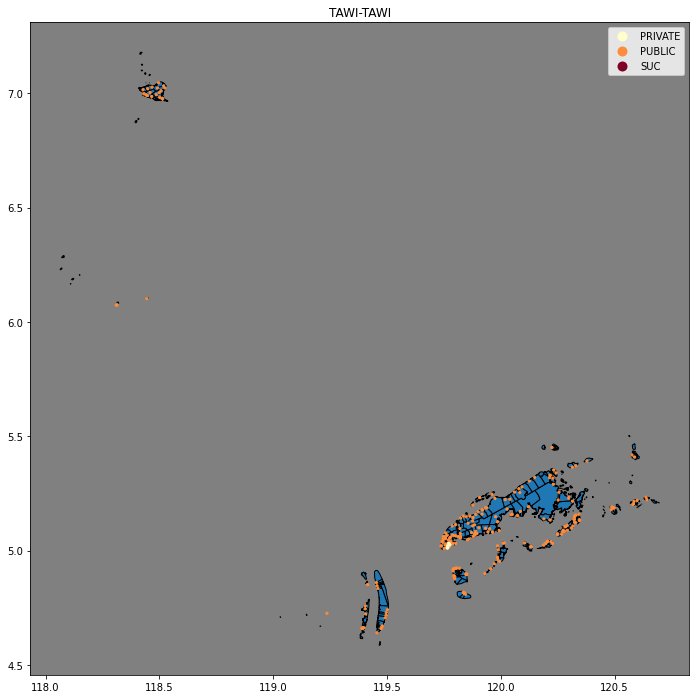

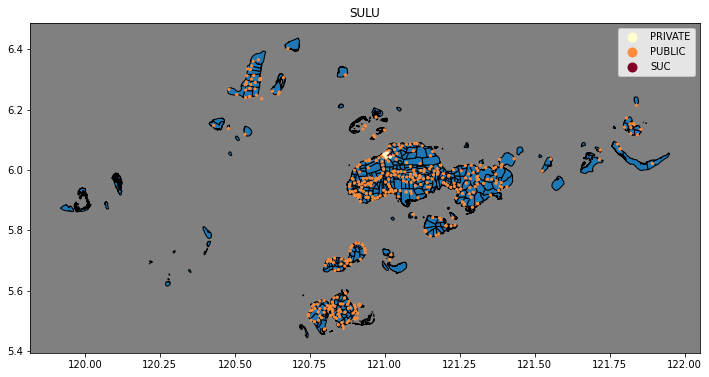

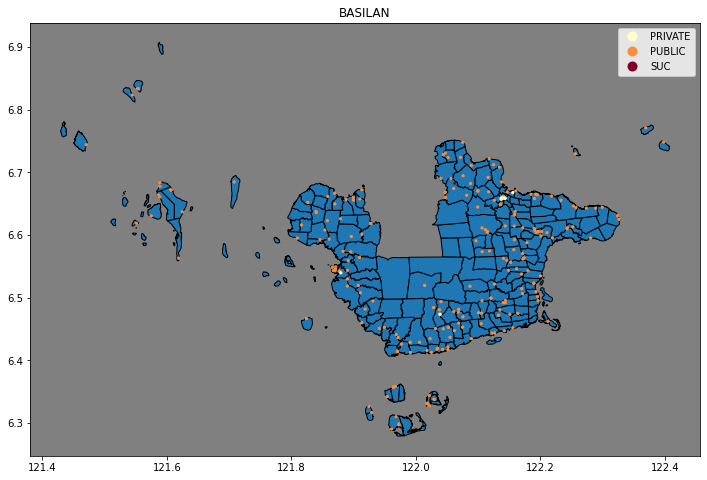

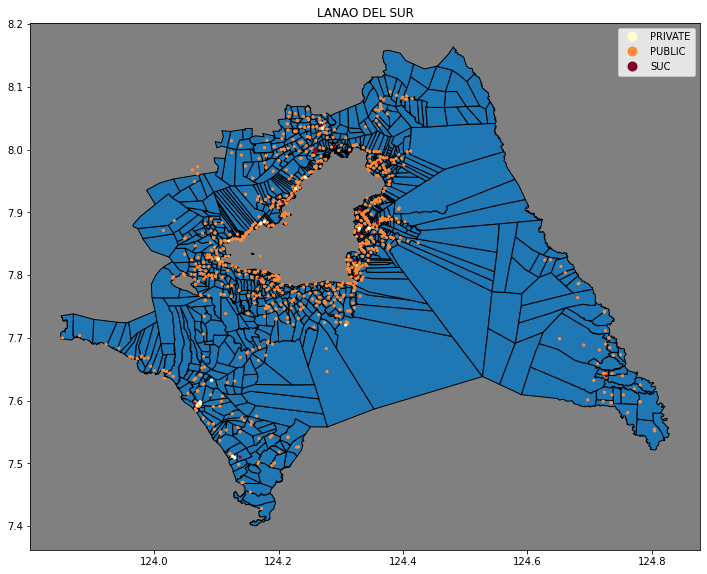

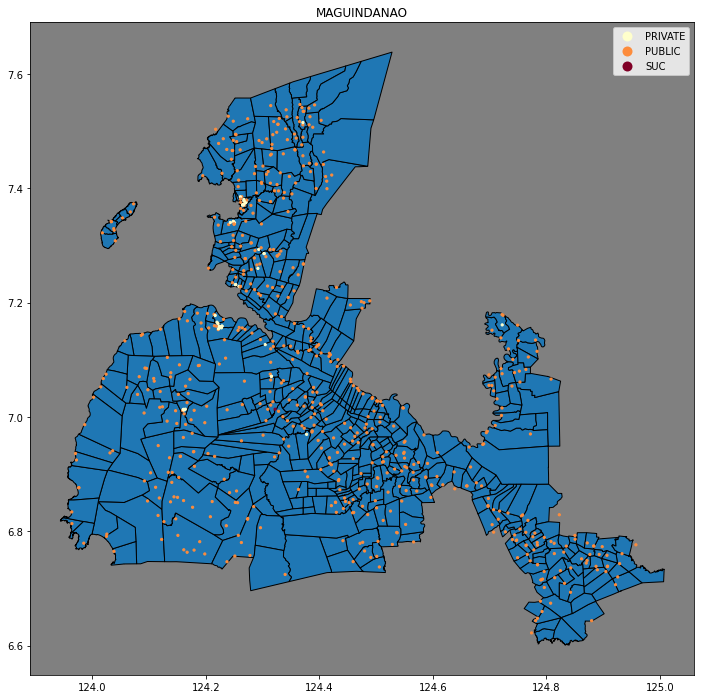

In [4]:
for province in brgys_geodata['Pro_Name'].unique():
    cond = brgys_geodata['Pro_Name']==province
    base = brgys_geodata[cond].plot(figsize=(12, 12),
                                    edgecolor="k")
    
    cond = schools_geodata['PROV']==province
    schools_geodata[cond].dropna()\
                         .plot(ax=base,
                               markersize=5,
                               column="SCH_TYPE",
                               cmap="YlOrRd",
                               legend=True)
    base.set_facecolor('grey')
    plt.title(province)
    plt.show();

In [5]:
brgys_popn.head()

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,Bgy_Name,geometry,PSGC_BRGY,both_age_6_to_16,total_popn,No_of_Schools
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Balimbing Proper,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",PH157001001,1610.0,5589.0,3.0
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Batu-batu (Pob.),"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",PH157001002,874.0,3794.0,2.0
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Buan,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",PH157001003,1248.0,4284.0,6.0
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Dungon,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",PH157001004,525.0,2117.0,1.0
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),Luuk Buntal,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",PH157001005,609.0,2569.0,2.0


In [6]:
brgys_pop_subset = brgys_popn.dropna(subset=["both_age_6_to_16"]).reset_index(drop=True)

spatial_weights = weights.Queen.from_dataframe(brgys_pop_subset)
brgys_pop_subset["w_both_age_6_to_16"] = weights.lag_spatial(spatial_weights, brgys_pop_subset["both_age_6_to_16"])

('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 86, ' is an island (no neighbors)')
('WARNING: ', 100, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 115, ' is an island (no neighbors)')
('WARNING: ', 124, ' is an island (no neighbors)')
('WARNING: ', 254, ' is an island (no neighbors)')
('WARNING: ', 284, ' is an island (no neighbors)')
('WARNING: ', 285, ' is an island (no neighbors)')
('WARNING: ', 286, ' is an island (no neighbors)')
('WARNING: ', 287, ' is an island (no neighbors)')
('WARNING: ', 355, ' is an island (no neighbors)')
('WARNING: ', 356, ' is an island (no neighbors)')
('WARNING: ', 363, ' is an island (no neighbors)')
('WARNING: ', 502, ' is an island (no neighbors)')
('WARNING: ', 513, ' is an island (no neighbors)')
('WARNING: ', 528, ' is an island (no neighbors)')
('WARNING: ', 575, ' is an island 

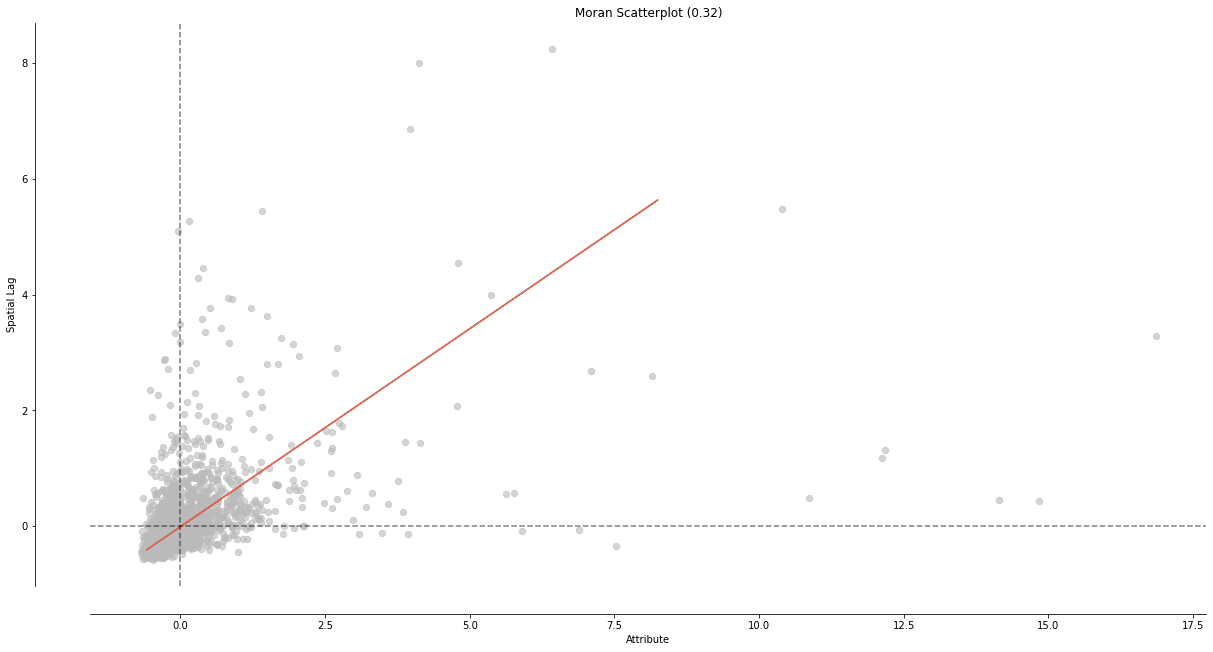

In [7]:
y = brgys_pop_subset["both_age_6_to_16"]
moran = Moran(y, spatial_weights)

fig, ax = moran_scatterplot(moran, aspect_equal=True)
fig.set_figheight(20)
fig.set_figwidth(20)
plt.show();

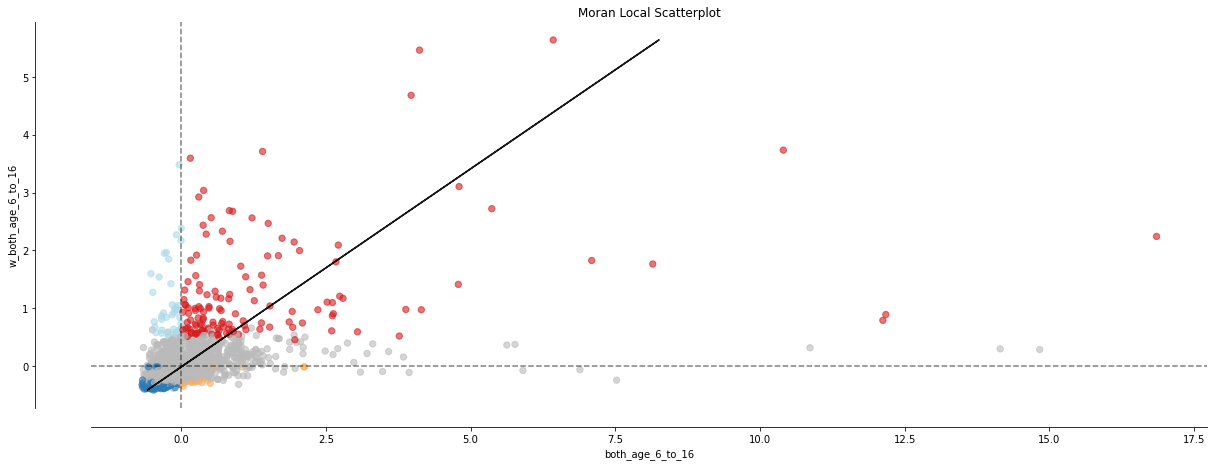

In [8]:
m_local = Moran_Local(y, spatial_weights,keep_simulations = False)

fig, ax = moran_scatterplot(m_local, p=0.05)
fig.set_figheight(20)
fig.set_figwidth(20)
ax.set_xlabel('both_age_6_to_16')
ax.set_ylabel("w_both_age_6_to_16")
plt.show()

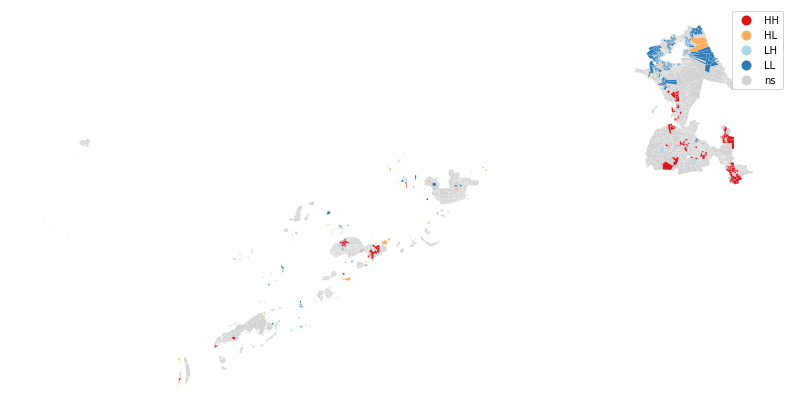

In [9]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(m_local, brgys_pop_subset, p=0.05, figsize = (20,20),ax=ax)
plt.show();